<a href="https://colab.research.google.com/github/moritala/MedicalFormDigitization/blob/master/NLP_Topic_Models_And_Evaluation_CFPBComplaints(Gensim_LDA_wo_alpha_and_eta).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1HCc7MbCk0-SVGGXf4om4HBlforJ34fy2'


2. Prerequisites – Download nltk stopwords and spacy model
3. Import Packages
4. What does LDA do?
5. Prepare Stopwords
6. Import Newsgroups Data
7. Remove emails and newline characters
8. Tokenize words and Clean-up text
9. Creating Bigram and Trigram Models
10. Remove Stopwords, Make Bigrams and Lemmatize
11. Create the Dictionary and Corpus needed for Topic Modeling
12. Building the Topic Model
13. View the topics in LDA model
14. Compute Model Perplexity and Coherence Score
15. Visualize the topics-keywords
16. Building LDA Mallet Model
17. How to find the optimal number of topics for LDA?
18. Finding the dominant topic in each sentence
19. Find the most representative document for each topic
20. Topic distribution across documents

In [3]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1HCc7MbCk0-SVGGXf4om4HBlforJ34fy2


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('chase_mortgage_complaints.csv')  

In [0]:
%load_ext google.colab.data_table

In [0]:
import pandas as pd
df = pd.read_csv('chase_mortgage_complaints.csv')
# Dataset is now stored in a Pandas Dataframe

In [0]:
original_df = df

In [9]:
df.columns

Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [10]:
df.shape

(21807, 19)

In [0]:
df.head(5)

In [0]:
pd.isnull(df['Consumer complaint narrative'])

In [0]:
df = df.dropna(subset=['Consumer complaint narrative'])

In [14]:
df.shape

(2884, 19)

In [0]:
df.head(5)

In [0]:
nullComments = pd.isnull(df['Consumer complaint narrative'])
nullComments

In [0]:
df[nullComments]

In [0]:
nonnullComments = pd.notnull(df['Consumer complaint narrative'])
nonnullComments

DataFrame with Non Null Comments 


In [0]:
df[nonnullComments]

In [0]:
df.head(5)

In [0]:
df[nullComments].shape[0] + df[nonnullComments].shape[0]

2884

In [21]:
original_df.shape[0]

21807

In [0]:
df = df[nonnullComments]
df.shape[0]

In [22]:
df.columns

Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [23]:
df.dtypes
df["Consumer complaint narrative"]= df["Consumer complaint narrative"].astype(str) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
!pip install spacy
!pip install pyLDAvis


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     |████████████████████████████████| 1.6MB 32.1MB/s 
     |████████████████████████████████| 552kB 53.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=529dff0a1e8dc7b0f059e2c3b0588846c9c990dcd1495cc9c07b1d0d5d5ccffc
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=89464f3427131d2a592ff38f72e89658e1c5de672a402c1cf16d27679ec738bf
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [0]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [36]:
# Convert to list
data = df['Consumer complaint narrative'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['I am filing this complaint after receiving a letter from Chase today '
 'alleging a lie to cover up their illegal activities. In the letter ( see '
 'attachment ) dated XX/XX/XXXX Chase asserted that we cant consider you for '
 'mortgage assistance because we didnt receive your initial request by the '
 'required number of days before the scheduled foreclosure date. THIS '
 'STATEMENT IS A LIE. I REPEAT. THIS STATEMENT IS A LIE, AND I CAN PROVE IT! '
 'Chase has repeatedly made false allegations like this to us for more than '
 'four years. Most of the Chase Request for Mortgage Assistance applications '
 'we have sent to Chase have been ignored ( see attachment ). Nonetheless, In '
 'XX/XX/XXXX, our Chase dedicated relationship manager in XXXX, Florida spoke '
 'to the Chase branch bank manager and vice president in XXXX, Georgia. He ( '
 'the vice president ) told her ( our dedicated relationship manager ) that he '
 'personally faxed all of our documents to her the previous week a

In [37]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['am', 'filing', 'this', 'complaint', 'after', 'receiving', 'letter', 'from', 'chase', 'today', 'alleging', 'lie', 'to', 'cover', 'up', 'their', 'illegal', 'activities', 'in', 'the', 'letter', 'see', 'attachment', 'dated', 'xx', 'xx', 'xxxx', 'chase', 'asserted', 'that', 'we', 'cant', 'consider', 'you', 'for', 'mortgage', 'assistance', 'because', 'we', 'didnt', 'receive', 'your', 'initial', 'request', 'by', 'the', 'required', 'number', 'of', 'days', 'before', 'the', 'scheduled', 'foreclosure', 'date', 'this', 'statement', 'is', 'lie', 'repeat', 'this', 'statement', 'is', 'lie', 'and', 'can', 'prove', 'it', 'chase', 'has', 'repeatedly', 'made', 'false', 'allegations', 'like', 'this', 'to', 'us', 'for', 'more', 'than', 'four', 'years', 'most', 'of', 'the', 'chase', 'request', 'for', 'mortgage', 'assistance', 'applications', 'we', 'have', 'sent', 'to', 'chase', 'have', 'been', 'ignored', 'see', 'attachment', 'nonetheless', 'in', 'xx', 'xx', 'xxxx', 'our', 'chase', 'dedicated', 'relations

In [38]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['am', 'filing', 'this', 'complaint', 'after', 'receiving', 'letter', 'from', 'chase', 'today', 'alleging', 'lie', 'to', 'cover', 'up', 'their', 'illegal', 'activities', 'in', 'the', 'letter', 'see', 'attachment', 'dated', 'xx', 'xx', 'xxxx', 'chase', 'asserted', 'that', 'we', 'cant', 'consider', 'you', 'for', 'mortgage', 'assistance', 'because', 'we', 'didnt', 'receive', 'your', 'initial', 'request', 'by', 'the', 'required', 'number', 'of', 'days', 'before', 'the', 'scheduled', 'foreclosure', 'date', 'this', 'statement', 'is', 'lie', 'repeat', 'this', 'statement', 'is', 'lie', 'and', 'can', 'prove', 'it', 'chase', 'has', 'repeatedly', 'made', 'false', 'allegations', 'like', 'this', 'to', 'us', 'for', 'more_than', 'four', 'years', 'most', 'of', 'the', 'chase', 'request', 'for', 'mortgage', 'assistance', 'applications', 'we', 'have', 'sent', 'to', 'chase', 'have', 'been', 'ignored', 'see', 'attachment', 'nonetheless', 'in', 'xx', 'xx', 'xxxx', 'our', 'chase', 'dedicated_relationship_man

In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [40]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['file', 'complaint', 'receive', 'letter', 'chase', 'today', 'allege', 'lie', 'cover', 'illegal', 'activity', 'letter', 'see', 'attachment', 'date', 'assert', 'can', 'consider', 'mortgage', 'assistance', 'receive', 'initial', 'request', 'require', 'number', 'day', 'schedule', 'foreclosure', 'date', 'statement', 'statement', 'lie', 'repeatedly', 'make', 'false', 'allegation', 'year', 'request', 'mortgage', 'assistance', 'application', 'send', 'ignore', 'see', 'attachment', 'nonetheless', 'speak', 'manager', 'tell', 'manager', 'personally', 'fax', 'document', 'previous', 'week', 'confirm', 'receipt', 'office', 'time', 'fact', 'request', 'branch', 'submit', 'application', 'require', 'document', 'rd', 'time', 'month', 'see', 'attachment', 'consequently', 'dedicated_relationship', 'manager', 'send', 'home', 'address', 'envelope', 'submit', 'application', 'document', 'back', 'seal', 'document', 'envelope', 'take', 'back', 'chase', 'employee', 'could', 'send', 'take', 'receipt', 'envelope', 

In [41]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 7), (7, 1), (8, 1), (9, 3), (10, 4), (11, 1), (12, 2), (13, 1), (14, 1), (15, 5), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 5), (23, 2), (24, 1), (25, 5), (26, 1), (27, 3), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 3), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 2), (43, 3), (44, 3), (45, 2), (46, 6), (47, 2), (48, 3), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 3), (69, 1), (70, 1), (71, 4), (72, 3), (73, 1), (74, 1), (75, 4), (76, 3), (77, 1), (78, 1), (79, 3), (80, 4), (81, 3), (82, 1), (83, 2), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1)]]


In [48]:
id2word[6]


'application'

In [49]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('action', 1),
  ('activity', 1),
  ('actual', 1),
  ('address', 1),
  ('allegation', 1),
  ('allege', 1),
  ('application', 7),
  ('aspect', 1),
  ('assert', 1),
  ('assistance', 3),
  ('attachment', 4),
  ('attempt', 1),
  ('back', 2),
  ('branch', 1),
  ('can', 1),
  ('chase', 5),
  ('complaint', 1),
  ('confirm', 2),
  ('consequently', 1),
  ('consider', 1),
  ('could', 1),
  ('cover', 1),
  ('date', 5),
  ('day', 2),
  ('dedicated_relationship', 1),
  ('document', 5),
  ('employee', 1),
  ('envelope', 3),
  ('fact', 1),
  ('fail', 1),
  ('failure', 1),
  ('false', 1),
  ('fax', 1),
  ('file', 1),
  ('foreclosure', 3),
  ('give', 1),
  ('hear', 1),
  ('home', 1),
  ('ignore', 1),
  ('illegal', 2),
  ('include', 1),
  ('initial', 1),
  ('law', 2),
  ('letter', 3),
  ('lie', 3),
  ('make', 2),
  ('manager', 6),
  ('month', 2),
  ('mortgage', 3),
  ('multiple', 1),
  ('never', 1),
  ('nonetheless', 1),
  ('notification', 1),
  ('number', 1),
  ('occasion', 1),
  ('office', 2),
  ('p

In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [51]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.173*"escrow" + 0.096*"pay" + 0.094*"taxis" + 0.084*"tax" + '
  '0.060*"property" + 0.055*"account" + 0.030*"discharge" + 0.028*"shortage" + '
  '0.014*"bill" + 0.011*"appropriate"'),
 (1,
  '0.095*"note" + 0.028*"security" + 0.017*"replace" + 0.017*"land" + '
  '0.016*"standard" + 0.016*"create" + 0.016*"misleading" + 0.015*"government" '
  '+ 0.012*"building" + 0.011*"provision"'),
 (2,
  '0.247*"payment" + 0.074*"mortgage" + 0.067*"make" + 0.041*"pay" + '
  '0.037*"month" + 0.035*"late" + 0.035*"chase" + 0.031*"xxxx" + 0.030*"due" + '
  '0.027*"monthly"'),
 (3,
  '0.088*"insurance" + 0.060*"fund" + 0.036*"policy" + 0.035*"escrow" + '
  '0.020*"increase" + 0.018*"analysis" + 0.016*"account" + 0.014*"homeowner" + '
  '0.013*"claim" + 0.012*"check"'),
 (4,
  '0.084*"application" + 0.064*"assistance" + 0.051*"program" + '
  '0.033*"borrower" + 0.026*"modification" + 0.025*"review" + 0.021*"option" + '
  '0.019*"income" + 0.019*"investor" + 0.017*"guideline"'),
 (5,
  '0.116*"ti

In [52]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.81012982814436

Coherence Score:  0.39189800158193555


In [53]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.284236 -0.094133       1        1  20.114222
14     0.254475  0.050782       2        1  19.757093
6      0.188419 -0.113502       3        1  10.179338
18     0.159671 -0.085689       4        1   8.913095
2      0.207531  0.131973       5        1   7.563638
15     0.181853  0.076909       6        1   6.638125
13     0.086074 -0.106369       7        1   5.161491
12     0.004656 -0.120012       8        1   2.802015
16    -0.016442  0.131022       9        1   2.757929
4     -0.054958 -0.217469      10        1   2.652020
17    -0.014954  0.216611      11        1   2.601274
3     -0.040427  0.178356      12        1   2.179598
8     -0.163708  0.011580      13        1   1.666424
9     -0.128256 -0.046766      14        1   1.181787
0     -0.098047  0.202644      15        1   1.163285
19    -0.144766 -0.133223      16        1   1.065875
5     -0.178391 -0.024693      17        1   1.029141
10    -0.170218 -0.045319      18        1   0.990771
1     -0.176890 -0.010106      19        1   0.963350
7     -0.179857 -0.002595      20        1   0.619536, topic_info=           Term         Freq        Total Category  logprob  loglift
210     payment  6025.000000  6025.000000  Default  30.0000  30.0000
191        loan  5239.000000  5239.000000  Default  29.0000  29.0000
278         pay  3281.000000  3281.000000  Default  28.0000  28.0000
297        call  2944.000000  2944.000000  Default  27.0000  27.0000
127      credit  1838.000000  1838.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
120    complete    41.992172   585.830872  Topic20  -3.8616   2.4484
1552  extension    16.874691    88.011902  Topic20  -4.7732   3.4323
2024  beginning    10.329582    22.150013  Topic20  -5.2640   4.3211
770        area    14.272394    85.808434  Topic20  -4.9407   3.2902
455          do    15.953158   550.750854  Topic20  -4.8294   1.5423

[1067 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4028     14  0.942604  abandon
1818     13  0.993053    abuse
3929     18  0.066219  abusive
3929     19  0.893961  abusive
91        1  0.150388   accept
...     ...       ...      ...
4762     14  0.932366     yard
89        2  0.749472     year
89        4  0.159268     year
89        5  0.088531     year
89       11  0.002604     year

[1694 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 15, 7, 19, 3, 16, 14, 13, 17, 5, 18, 4, 9, 10, 1, 20, 6, 11, 2, 8])

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start,step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=5)


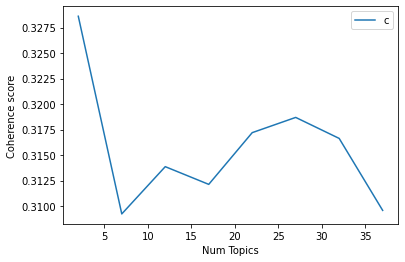

In [112]:
# Show graph
limit=40; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [113]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3286
Num Topics = 7  has Coherence Value of 0.3092
Num Topics = 12  has Coherence Value of 0.3139
Num Topics = 17  has Coherence Value of 0.3121
Num Topics = 22  has Coherence Value of 0.3172
Num Topics = 27  has Coherence Value of 0.3187
Num Topics = 32  has Coherence Value of 0.3166
Num Topics = 37  has Coherence Value of 0.3096


In [114]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.019*"home" + 0.015*"chase" + 0.013*"send" + 0.013*"pay" + '
  '0.012*"mortgage" + 0.012*"would" + 0.011*"loan" + 0.010*"tell" + '
  '0.010*"year" + 0.009*"receive"'),
 (13,
  '0.027*"mortgage" + 0.024*"chase" + 0.017*"payment" + 0.015*"modification" + '
  '0.015*"time" + 0.014*"loan" + 0.014*"home" + 0.011*"xxxx" + 0.011*"year" + '
  '0.011*"tell"'),
 (15,
  '0.022*"loan" + 0.019*"chase" + 0.012*"day" + 0.011*"property" + '
  '0.011*"payment" + 0.010*"pay" + 0.010*"mortgage" + 0.009*"tell" + '
  '0.009*"receive" + 0.008*"xxxx"'),
 (9,
  '0.026*"chase" + 0.022*"loan" + 0.020*"xxxx" + 0.015*"account" + '
  '0.011*"mortgage" + 0.011*"send" + 0.010*"also" + 0.010*"payment" + '
  '0.009*"report" + 0.008*"pay"'),
 (10,
  '0.024*"loan" + 0.022*"mortgage" + 0.017*"home" + 0.016*"chase" + '
  '0.010*"pay" + 0.009*"document" + 0.009*"foreclosure" + 0.008*"xxxx" + '
  '0.007*"receive" + 0.007*"modification"'),
 (20,
  '0.023*"chase" + 0.017*"property" + 0.013*"offer" + 0.011*"file" + '


In [115]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.022988 -0.018858       1        1  20.437155
13     0.060407 -0.017723       2        1  12.464777
26     0.064268 -0.029857       3        1  11.294506
19     0.005860 -0.032027       4        1   9.519550
4      0.047928  0.000866       5        1   4.891372
21     0.061350 -0.001975       6        1   4.886434
6      0.017212 -0.024886       7        1   4.750866
1     -0.037982 -0.048783       8        1   4.292745
9      0.007477 -0.009840       9        1   2.969172
25     0.062325  0.017491      10        1   2.846979
10    -0.031016 -0.027980      11        1   2.436960
20    -0.027984 -0.048270      12        1   2.436028
2     -0.006377 -0.018689      13        1   2.274846
0      0.012181 -0.022835      14        1   1.849752
14     0.038161  0.007421      15        1   1.778306
12     0.029985  0.014080      16        1   1.641080
23     0.017952  0.001556      17        1   1.596583
18    -0.185126 -0.060588      18        1   1.525719
16     0.003042  0.004304      19        1   1.518361
15     0.003613 -0.004614      20        1   1.343049
5      0.006777 -0.009650      21        1   0.973568
11    -0.000901  0.032908      22        1   0.632747
22    -0.006227  0.024005      23        1   0.562092
24    -0.028021  0.057524      24        1   0.338571
7     -0.016289  0.051392      25        1   0.292699
3     -0.060390  0.047357      26        1   0.277401
8     -0.061213  0.117671      27        1   0.168676, topic_info=          Term         Freq        Total Category  logprob  loglift
191       loan  4922.000000  4922.000000  Default  30.0000  30.0000
210    payment  6087.000000  6087.000000  Default  29.0000  29.0000
15       chase  7093.000000  7093.000000  Default  28.0000  28.0000
278        pay  3284.000000  3284.000000  Default  27.0000  27.0000
48    mortgage  5678.000000  5678.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
205     notice     1.867164   516.757080  Topic27  -5.6736   0.7618
16   complaint     1.921745   781.617493  Topic27  -5.6448   0.3768
48    mortgage     2.214168  5678.259766  Topic27  -5.5032  -1.4646
25    document     1.993397  1634.666138  Topic27  -5.6082  -0.3244
225  refinance     1.836808   655.629333  Topic27  -5.6900   0.5074

[2054 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
6719      4  0.256116  abatement
6719     10  0.512232  abatement
3801     18  0.614555       abet
417       1  0.169682       able
417       2  0.169682       able
...     ...       ...        ...
89       26  0.002636       year
89       27  0.001318       year
8514      7  0.390730  yearsthis
8514     26  0.390730  yearsthis
4822      7  0.753587       zone

[8242 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 14, 27, 20, 5, 22, 7, 2, 10, 26, 11, 21, 3, 1, 15, 13, 24, 19, 17, 16, 6, 12, 23, 25, 8, 4, 9])

In [134]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  ...                                               Text
0            0  ...  I am filing this complaint after receiving a l...
1            1  ...  Dear Senator XXXX, AGO XXXX and Consumer Prote...
2            2  ...  I currently have a LTV of 78.00 % on my curren...
3            3  ...  JP Morgan CHASE RE : Loan # XXXX FHA Case # XX...
4            4  ...  We are victims of excessive Mortgage Fraud. It...
5            5  ...  Chase bank charged over {$3000.00} in Corporat...
6            6  ...  I recently financed a home purchase through JP...
7            7  ...  In XX/XX/2018, Chase Bank internally misapplie...
8            8  ...  We signed on a mortgage with two other people....
9            9  ...  We had a loan with chase, and we ended up in p...

[10 rows x 5 columns]

In [136]:
df_dominant_topic

Document_No  ...                                               Text
0               0  ...  I am filing this complaint after receiving a l...
1               1  ...  Dear Senator XXXX, AGO XXXX and Consumer Prote...
2               2  ...  I currently have a LTV of 78.00 % on my curren...
3               3  ...  JP Morgan CHASE RE : Loan # XXXX FHA Case # XX...
4               4  ...  We are victims of excessive Mortgage Fraud. It...
...           ...  ...                                                ...
2879         2879  ...  Throught all of the delays with Chase, I had t...
2880         2880  ...  On XX/XX/2019, I submitted an online payment o...
2881         2881  ...  I have a home mortgage with Chase. I had an ov...
2882         2882  ...  After trying to get a Mortgage Modification si...
2883         2883  ...  I can not get from chase who services my mortg...

[2884 rows x 5 columns]

In [117]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  ...                                               Text
0        0.0  ...  I applied for & was told {$500.00} is required...
1        1.0  ...  JP Morgan Chase closed homeowner s Original Lo...
2        2.0  ...  This is a Follow-up my previous complaint # XX...
3        3.0  ...  I applied for a loan mod with Chase. A complet...
4        4.0  ...  My husband and I currently have a home equity ...

[5 rows x 4 columns]

In [133]:
sent_topics_sorteddf_mallet

Topic_Num  ...                                               Text
0         0.0  ...  I applied for & was told {$500.00} is required...
1         1.0  ...  JP Morgan Chase closed homeowner s Original Lo...
2         2.0  ...  This is a Follow-up my previous complaint # XX...
3         3.0  ...  I applied for a loan mod with Chase. A complet...
4         4.0  ...  My husband and I currently have a home equity ...
5         5.0  ...  Name : XXXX XXXX AKA XXXX XXXXPrimary Business...
6         6.0  ...  XX/XX/XXXX started a mortgage with Washington ...
7         7.0  ...  Hello, I have a conventional mortgage with Cha...
8         8.0  ...  Please accept this narrow and specific Qualifi...
9         9.0  ...  Due to ongoing violations by Chase of CFPB bul...
10       10.0  ...  I applied to refinance my home mortgage with C...
11       11.0  ...  Chase LN XXXX XXXX XXXX XXXX and XXXX XXXX XXX...
12       12.0  ...  I am losing my home. My home became default fo...
13       13.0  ...  I fell behind on my mortgage back around XX/XX...
14       14.0  ...  My son and his fiance wanted to buy a home tog...
15       15.0  ...  In the past few days I received a notice as se...
16       16.0  ...  My wife and I had voiced a complaint about the...
17       17.0  ...  It is getting extremely old and obvious that J...
18       18.0  ...  This complaint is in regard to a Home Equity L...
19       19.0  ...  To whom it may concern : The investor or owner...
20       20.0  ...  Doing a short sale with Chase on an FHA loan. ...
21       21.0  ...  Currently I have a mortgage account with Chase...
22       22.0  ...  WAMU had steered my mother and sister toward a...
23       23.0  ...  Chase Mortgage : I was behind 2 mortgage payme...
24       24.0  ...  I seemed to have misplaced my old mortgage inf...
25       25.0  ...  I purchased my home through Chase mortgage in ...
26       26.0  ...  Our conventional mortgage was originated in XX...

[27 rows x 4 columns]

In [118]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

Dominant_Topic  ... Perc_Documents
0.0               19.0  ...         0.0225
1.0               13.0  ...         0.0399
2.0               19.0  ...         0.0173
3.0               19.0  ...         0.0049
4.0               18.0  ...         0.0472
...                ...  ...            ...
2879.0            19.0  ...            NaN
2880.0            17.0  ...            NaN
2881.0            26.0  ...            NaN
2882.0            12.0  ...            NaN
2883.0            10.0  ...            NaN

[2884 rows x 4 columns]

In [81]:
#@title TODO - Find MalletPath and Run Again
link_zip= 'https://drive.google.com/open?id=1ZYza6vvETXBe-UrscmNbkDT_IKz-1crQ'

fluff, id1 = link_zip.split('=')
print (id1) # Verify that you have everything after '='

downloaded1 = drive.CreateFile({'id':id1}) 
downloaded1.GetContentFile('mallet')
downloaded1
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

1ZYza6vvETXBe-UrscmNbkDT_IKz-1crQ


GoogleDriveFile({'id': '1ZYza6vvETXBe-UrscmNbkDT_IKz-1crQ', 'kind': 'drive#file', 'etag': '"LrGgEMAIqqQuhm7ovRQX7yBBvMY/MTU4NTY4OTQyOTk2OQ"', 'selfLink': 'https://www.googleapis.com/drive/v2/files/1ZYza6vvETXBe-UrscmNbkDT_IKz-1crQ', 'webContentLink': 'https://drive.google.com/uc?id=1ZYza6vvETXBe-UrscmNbkDT_IKz-1crQ&export=download', 'alternateLink': 'https://drive.google.com/file/d/1ZYza6vvETXBe-UrscmNbkDT_IKz-1crQ/view?usp=drivesdk', 'embedLink': 'https://drive.google.com/file/d/1ZYza6vvETXBe-UrscmNbkDT_IKz-1crQ/preview?usp=drivesdk', 'iconLink': 'https://drive-thirdparty.googleusercontent.com/16/type/application/x-shellscript', 'title': 'mallet', 'mimeType': 'application/x-shellscript', 'labels': {'starred': False, 'hidden': False, 'trashed': False, 'restricted': False, 'viewed': True}, 'copyRequiresWriterPermission': False, 'createdDate': '2020-03-31T21:15:32.141Z', 'modifiedDate': '2020-03-31T21:17:09.969Z', 'modifiedByMeDate': '2020-03-31T21:17:09.969Z', 'lastViewedByMeDate': '202

In [0]:
import os
from gensim.models.wrappers import LdaMallet

In [130]:
mallet_path = 'mallet/mallet-2.0.8/bin/mallet' # update this path


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CalledProcessError: ignored

In [131]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CalledProcessError: ignored